In [161]:
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4 # library for reading netCDF (.nc) files
import numpy as np
from datetime import datetime
import math
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib

In [3]:
def get_sm(lat, lon, date):
    '''
    Gets data from nc for specified lat and lon coordinates
    As well as for the respictive date
    
    Params:
     lat(float): Latitude coordinates
     lon(float): Longitude coordinates
     date(str): Date in the format yyyymmdd
    '''
    
    
    fp = "C3S-SOILMOISTURE-L3S-SSMV-COMBINED-DAILY-{}000000-TCDR-v201912.0.0.nc".format(date)
    nc = netCDF4.Dataset(fp, format="NETCDF4")
    
    # first convert coordinates
    for i, val in enumerate(nc.variables['lat'][:].data):
        if val < lat:
            lat_pos = i-1
            break
    
    for j, val in enumerate(nc.variables['lon'][:]):
        if val > lon:
            lon_pos = j-1
            break
    
    # this gives us a masked np.array
    tmp = nc['sm'][0, lat_pos:lat_pos+2, lon_pos:lon_pos+2] # first index is 0 because temporal resolution is 1 day
    # obtaining the actual value
    return tmp[~tmp.mask].data        

In [77]:
def convert_date(date, days=0, as_datetime=False):
    '''
    helper function to convert date such that NASA database can be queried
    '''
    date = date.split('/')
    date = '20{}-{}-{}'.format(date[2], date[0].zfill(2), date[1].zfill(2))
    
    date_t = datetime.strptime(date, "%Y-%m-%d")
    
    date_t = add_days(date_t, days)
    
    if as_datetime:
        return date_t
    
    return date_t.strftime("%Y%m%d")

In [72]:
def add_days(date, days=0):
    return(date + timedelta(days=days))

In [11]:
data = pd.read_csv('training_dataset_loc10.csv')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (6801) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [69]:
date = data['Plant date'].values[0]
lat = data['GPS LAT'].values[0]
lon = data['GPS LON'].values[0]



In [70]:
get_sm(lat, lon, convert_date(date))

array([[[0.25205112, 0.25538832],
        [0.27499917, 0.25534597]]], dtype=float32)

In [99]:
moists = dict()
for loc in pd.unique(data['LOC']):
    data_loc = data[data['LOC']==loc]
    LAT, LON = data_loc['GPS LAT'].values[0], data_loc['GPS LON'].values[0]
    start_date, end_date = data_loc['Plant date'].values[0], data_loc['Harvest date'].values[0]
    

    
    num_days = abs((convert_date(start_date, as_datetime=True) - 
                    convert_date(end_date, as_datetime=True)).days)
    
    moists[loc] = []
    for i in range(0, num_days):
        mean_moist = get_sm(LAT, LON, convert_date(start_date,i)).mean()
        if not math.isnan(mean_moist):
            moists[loc].append(mean_moist)
        
        
    #phenotypes.loc[phenotypes['LOC'] == loc, 'moist' + i]
    

<ipython-input-99-f78cd07a957d>:14: RuntimeWarning: Mean of empty slice.
  mean_moist = get_sm(LAT, LON, convert_date(start_date,i)).mean()


In [240]:
def make_bins(data, num_bins=10):    
    n = len(data)
    # divide data points into logarithmic bins, i.e. the first data points have higher
    # weighting than the later ones
    indices = 10**np.linspace(np.log10(1), np.log10(n), num_bins)

    # change bins to integers without duplicates
    for i in range(1, len(indices)):
    
        if (int(indices[i]) > indices[i-1]):
            indices[i] = int(indices[i])
        else:
            indices[i] = int(indices[i-1]) + 1    


     # sanity check
    if (max(indices) > n):
        raise("invalid number of datapoints")   


    aggregated = []
    # aggregate data in the specified bins
    for i in range(0, len(indices)):
        if (i > 0):
            # average from bin boundary to next bin boundary
            aggregated.append(np.mean(data[int(indices[i-1]):int(indices[i])]))
        else:
            aggregated.append(data[0])

    return(indices, aggregated)            


In [113]:
for loc in pd.unique(data['LOC']):
    bins = make_bins(moists[loc])
    for i, bin in enumerate(bins):
        data.loc[data['LOC'] == loc, "moist" + str(i + 1)] = bins[i]

In [116]:
data.to_csv("training_dataset_loc10_moist.csv", index=False)

In [118]:
pd.read_csv("training_dataset_loc10_moist.csv")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (6801) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,SampleID,PZE-101000169,AX-90587258,PZE-101000370,PZE-101000442,SYN8296,PZE-101001103,AX-90528473,AX-90635671,SYN6001,...,moist1,moist2,moist3,moist4,moist5,moist6,moist7,moist8,moist9,moist10
0,CI6621/I10516.DH004,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.259446,0.264035,0.298581,0.282501,0.261666,0.331889,0.344986,0.322186,0.351305,0.308706
1,CI6621/I10516.DH004,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.259446,0.264035,0.298581,0.282501,0.261666,0.331889,0.344986,0.322186,0.351305,0.308706
2,CI6621/I10516.DH004,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.269434,0.246245,0.239976,0.326334,0.305486,0.315771,0.317547,0.318892,0.334822,0.284778
3,CI6621/I10516.DH004,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.269434,0.246245,0.239976,0.326334,0.305486,0.315771,0.317547,0.318892,0.334822,0.284778
4,CI6621/I10516.DH004,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.259446,0.264035,0.298581,0.282501,0.261666,0.331889,0.344986,0.322186,0.351305,0.308706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5943,FF6224/I9005.DH132_+_I10516,0.5,1.0,0.5,0.5,0.5,0.5,0.5,1.0,1.0,...,0.379176,0.359624,0.348236,0.341909,0.375875,0.342216,0.353047,0.301573,0.362612,0.345793
5944,FF6224/I9005.DH132_+_I10516,0.5,1.0,0.5,0.5,0.5,0.5,0.5,1.0,1.0,...,0.379176,0.359624,0.348236,0.341909,0.375875,0.342216,0.353047,0.301573,0.362612,0.345793
5945,FF6224/I9005.DH132_+_I10516,0.5,1.0,0.5,0.5,0.5,0.5,0.5,1.0,1.0,...,0.274822,0.288151,0.303927,0.362010,0.335868,0.365879,0.343347,0.350693,0.367652,0.347358
5946,FF6224/I9005.DH132_+_I10516,0.5,1.0,0.5,0.5,0.5,0.5,0.5,1.0,1.0,...,0.274822,0.288151,0.303927,0.362010,0.335868,0.365879,0.343347,0.350693,0.367652,0.347358


In [124]:
# Visualize Moisture Data

In [135]:
# get indices for the plot
df = pd.read_csv('https://power.larc.nasa.gov/downloads/POWER_SinglePoint_Daily_20150505_20150910_040d19N_86d80W_af064dd4.csv',
                  skiprows=13, na_values = [-99,-999])  # importing taking into account header rows and missing values

In [137]:
df['Date'] = pd.to_datetime(df['YEAR'] * 1000 + df['DOY'], format="%Y%j")   #recalculating actual date for each observation


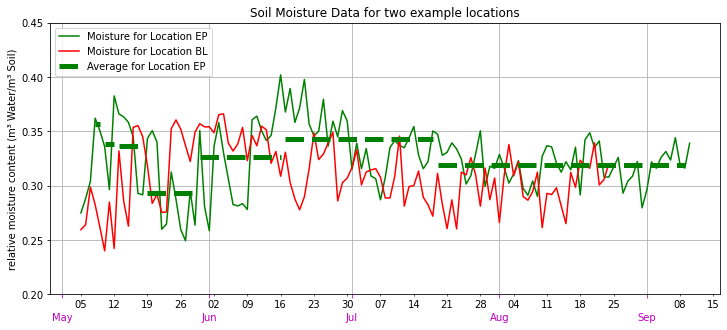

In [263]:
fig, ax1 = plt.subplots()
ax1.plot(Dates, moists['EP'], 'g', label='Moisture for Location EP')
ax1.set_ylim(0.2,0.45)
ax1.plot(Dates[:112], moists['BL'], 'r', label="Moisture for Location BL")

ax1.grid(True)
ax1.legend(loc='upper left')
ax1.set_ylabel("relative moisture content (m³ Water/m³ Soil)")

indices, bins = make_bins(moists['EP'])
for i in range(1, len(indices)):
    ax1.plot(Dates[range(int(indices[i-1]),int(indices[i]))], (int(indices[i]) - int(indices[i-1])) * [bins[i]], linewidth=5, 
             color='g', linestyle='dashed', label='Average for Location EP')
    if (i==1):
        ax1.grid(True)
        ax1.legend(loc='upper left')
        
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_minor_locator(days)
ax1.xaxis.set_minor_formatter(minFmt)
ax1.xaxis.set_tick_params(which='major', color='m', labelcolor='m', pad=15)
ax1.set_title("Soil Moisture Data for two example locations");